# Approche Non Supervisée (LDA)

## Objectifs
- Mettre en œuvre une approche non supervisée de proposition de mots-clés
- Utiliser LDA (Latent Dirichlet Allocation) pour le topic modeling
- Visualisation 2D des topics avec pyLDAvis
- Tracking des expérimentations avec MLflow

**Principe** : LDA identifie des thèmes latents dans le corpus de textes, sans utiliser les tags existants. Chaque thème est caractérisé par un ensemble de mots-clés.

## 1. Imports et Configuration

In [2]:

# IMPORTS
import pandas as pd
import numpy as np
import warnings

# Gensim pour LDA
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

# Visualisation
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# MLflow pour le tracking
import mlflow
from mlflow.exceptions import MlflowException

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')



In [3]:
# Configuration MLFlow
mlflow.set_tracking_uri("file:///C:/Users/lza/Documents/P05_Projet_tags_StackOverflow/mlruns")
print(f" MLFlow Tracking URI : {mlflow.get_tracking_uri()}")

 MLFlow Tracking URI : file:///C:/Users/lza/Documents/P05_Projet_tags_StackOverflow/mlruns


## 2. Chargement des Données Prétraitées

In [6]:
# Chargement des données prétraitées du Notebook 1
df_train = pd.read_csv('../data/processed/df_preprocessed.csv')

# Vérification
print(f" Dataset chargé : {df_train.shape[0]} documents")
print(f"\nColonnes disponibles : {df_train.columns.tolist()}")

# Vérifier que Tokens_LDA existe
if 'Tokens_LDA' not in df_train.columns:
    raise ValueError("La colonne 'Tokens_LDA' n'existe pas. Exécutez d'abord le Notebook 1.")

print(f"\nExemple de tokens LDA :")
print(df_train['Tokens_LDA'].iloc[0][:200])

 Dataset chargé : 50000 documents

Colonnes disponibles : ['Title', 'Body', 'Tags', 'Id', 'Score', 'ViewCount', 'FavoriteCount', 'AnswerCount', 'title_length', 'body_length', 'Tags_List', 'num_tags', 'Text_Raw', 'Text_Cleaned', 'Tokens_LDA', 'Tokens_DL', 'Tags_Filtered']

Exemple de tokens LDA :
paging collection linq how page collection linq given startindex count


## 3. Préparation du Corpus pour LDA

In [ ]:
print(" Création du Dictionnaire et du Corpus LDA...")

# Convertir les tokens en listes de mots
texts = df_train['Tokens_LDA'].apply(str.split).tolist()

# 1. Création du Dictionnaire (mapping mot -> id)
dictionary = corpora.Dictionary(texts)
print(f"   - Vocabulaire initial : {len(dictionary)} mots")

# 2. Filtrage des Extrêmes (mots trop rares ou trop fréquents)
dictionary.filter_extremes(
    no_below=5,     # Ignorer les mots apparaissant dans moins de 5 documents
    no_above=0.5    # Ignorer les mots apparaissant dans plus de 50% des documents
)
print(f"   - Vocabulaire après filtrage : {len(dictionary)} mots")

# 3. Création du Corpus (format Bag-of-Words)
corpus = [dictionary.doc2bow(text) for text in texts]

print(f"\n Préparation du Corpus LDA terminée")
print(f"   - Taille du vocabulaire final : {len(dictionary)} mots")
print(f"   - Nombre de documents : {len(corpus)}")

 Création du Dictionnaire et du Corpus LDA...
   - Vocabulaire initial : 334183 mots
   - Vocabulaire après filtrage : 24054 mots

 Préparation du Corpus LDA terminée
   - Taille du vocabulaire final : 24054 mots
   - Nombre de documents : 50000


## 4. Entraînement du Modèle LDA

In [7]:
# Configuration de l'expérience MLFlow
EXPERIMENT_NAME = "Approche_Non_Supervisee_LDA"

try:
    mlflow.set_experiment(EXPERIMENT_NAME)
    print(f"Expérience MLFlow : {EXPERIMENT_NAME}")
except MlflowException:
    mlflow.create_experiment(EXPERIMENT_NAME)
    mlflow.set_experiment(EXPERIMENT_NAME)
    print(f" Nouvelle expérience créée : {EXPERIMENT_NAME}")

Expérience MLFlow : Approche_Non_Supervisee_LDA


In [6]:
# --- Hyperparamètres ---
NUM_TOPICS = 10  # Nombre de thèmes à découvrir
PASSES = 15      # Nombre d'itérations sur le corpus
ALPHA = 'auto'   # Distribution des topics par document
ETA = 'auto'     # Distribution des mots par topic

print(f"\n Démarrage de l'entraînement LDA")
print(f"   - Nombre de topics : {NUM_TOPICS}")
print(f"   - Passes : {PASSES}")

with mlflow.start_run(run_name=f"LDA_Topics_{NUM_TOPICS}_V1") as run:
    
    # 1. Enregistrement des paramètres
    mlflow.log_params({
        "num_topics": NUM_TOPICS,
        "passes": PASSES,
        "alpha": str(ALPHA),
        "eta": str(ETA),
        "model": "LDA",
        "vocab_size": len(dictionary),
        "corpus_size": len(corpus)
    })
    
    # 2. Entraînement du modèle LDA
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=NUM_TOPICS,
        random_state=42,
        passes=PASSES,
        alpha=ALPHA,
        eta=ETA,
        per_word_topics=True
    )
    
    # 3. Évaluation avec le Coherence Score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'  # Coherence c_v est recommandée
    )
    coherence_score = coherence_model.get_coherence()
    
    # 4. Calcul de la perplexité
    perplexity = lda_model.log_perplexity(corpus)
    
    # 5. Enregistrement des métriques
    mlflow.log_metric("coherence_score", coherence_score)
    mlflow.log_metric("perplexity", perplexity)
    
    print(f"\ Entraînement terminé")
    print(f"   - Coherence Score (c_v) : {coherence_score:.4f}")
    print(f"   - Perplexité : {perplexity:.4f}")
    print(f"\n Run MLFlow ID : {run.info.run_id}")


 Démarrage de l'entraînement LDA
   - Nombre de topics : 10
   - Passes : 15
\ Entraînement terminé
   - Coherence Score (c_v) : 0.5786
   - Perplexité : -7.7902

 Run MLFlow ID : e4aeeea6276c4ecb9e91c5a0991a7bf6


## 5. Analyse des Topics (Mots-Clés Proposés)

In [7]:
# Affichage des mots-clés par topic
print("SUGGESTIONS DE MOTS-CLÉS PAR THÈME")

for idx, topic in lda_model.print_topics(num_topics=-1, num_words=8):
    # Extraire uniquement les mots (sans les poids)
    words = [word.split('*')[1].strip('"') for word in topic.split(' + ')]
    print(f"\n Thème {idx + 1}:")
    print(f"   Mots-clés : {', '.join(words)}")
    print(f"   Brut : {topic}")

SUGGESTIONS DE MOTS-CLÉS PAR THÈME

 Thème 1:
   Mots-clés : public, int, new, string, android, void, private, return
   Brut : 0.064*"public" + 0.046*"int" + 0.045*"new" + 0.040*"string" + 0.036*"android" + 0.032*"void" + 0.021*"private" + 0.021*"return"

 Thème 2:
   Mots-clés : image, event, button, item, new, map, control, screen
   Brut : 0.036*"image" + 0.028*"event" + 0.021*"button" + 0.021*"item" + 0.019*"new" + 0.012*"map" + 0.011*"control" + 0.011*"screen"

 Thème 3:
   Mots-clés : n't, like, using, would, way, use, how, want
   Brut : 0.016*"n't" + 0.014*"like" + 0.014*"using" + 0.013*"would" + 0.012*"way" + 0.012*"use" + 0.010*"how" + 0.010*"want"

 Thème 4:
   Mots-clés : value, string, array, list, name, number, return, line
   Brut : 0.033*"value" + 0.028*"string" + 0.022*"array" + 0.019*"list" + 0.013*"name" + 0.013*"number" + 0.013*"return" + 0.012*"line"

 Thème 5:
   Mots-clés : file, server, error, project, message, version, path, directory
   Brut : 0.044*"file" + 

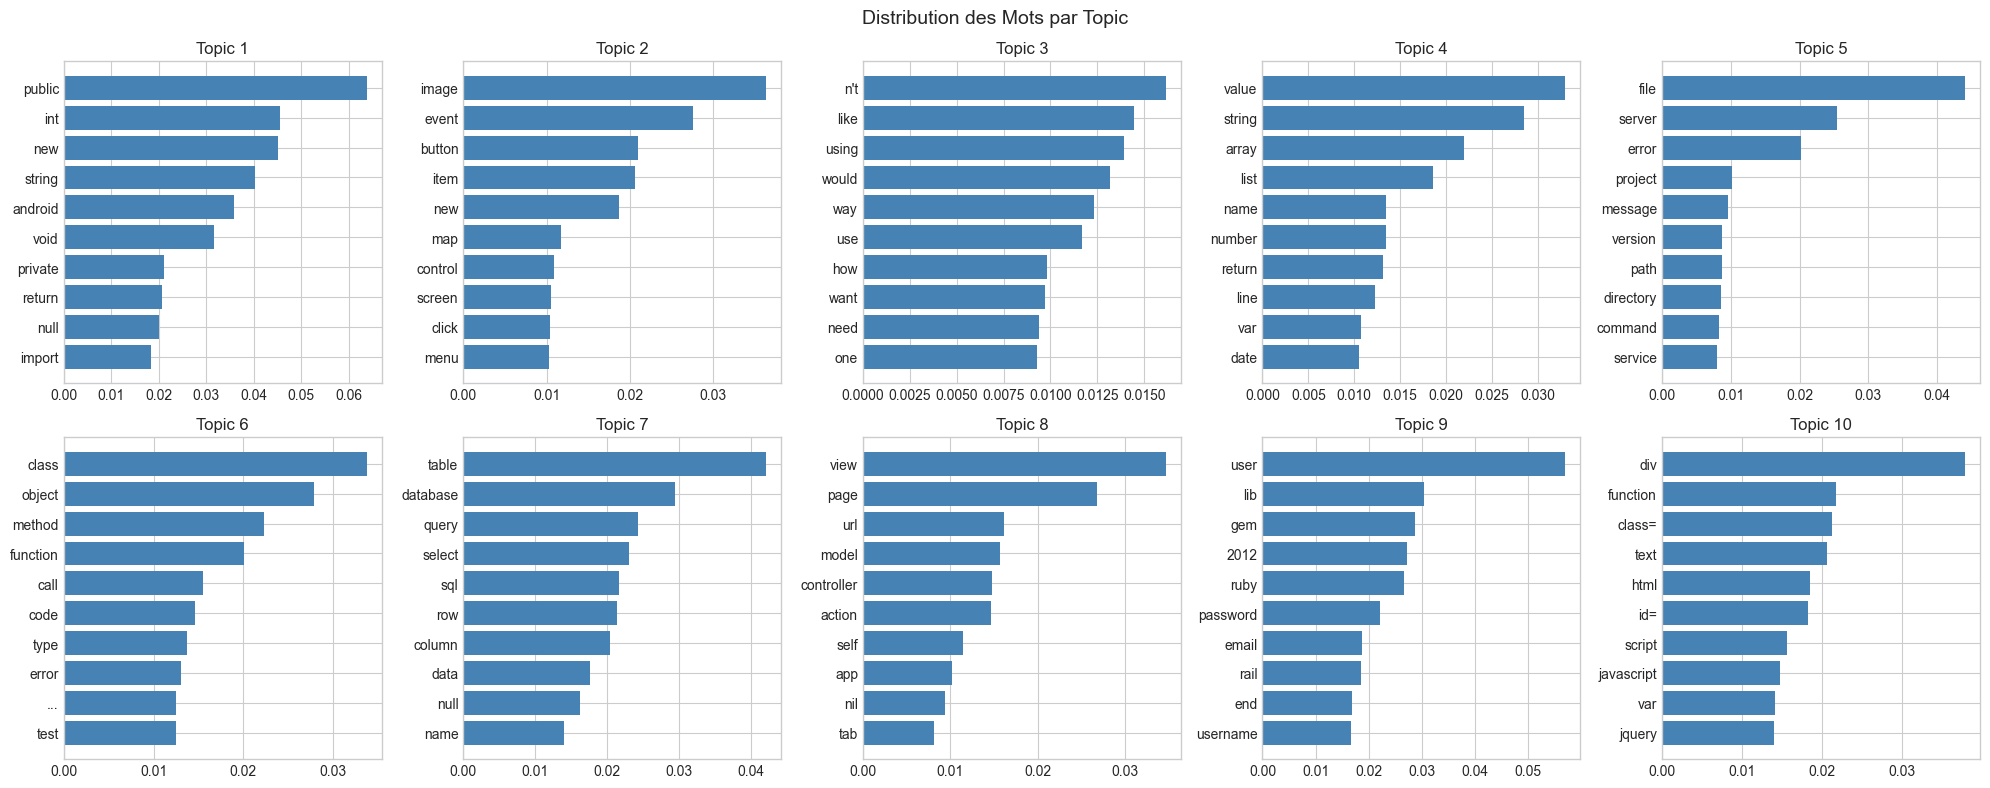

In [8]:
# Visualisation des poids des mots par topic
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx in range(NUM_TOPICS):
    topic_words = lda_model.show_topic(idx, topn=10)
    words = [word for word, _ in topic_words]
    weights = [weight for _, weight in topic_words]
    
    axes[idx].barh(words, weights, color='steelblue')
    axes[idx].set_title(f'Topic {idx + 1}')
    axes[idx].invert_yaxis()

plt.suptitle('Distribution des Mots par Topic', fontsize=14)
plt.tight_layout()
plt.savefig('lda_topics_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Visualisation 2D avec pyLDAvis

In [9]:
# Préparation de la visualisation pyLDAvis
print(" Génération de la visualisation pyLDAvis...")

# Préparer les données pour pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Afficher dans le notebook
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_data)

 Génération de la visualisation pyLDAvis...


In [10]:
# Sauvegarder la visualisation en HTML
pyLDAvis.save_html(vis_data, 'lda_visualization.html')
print("\n Visualisation sauvegardée dans 'lda_visualization.html'")


 Visualisation sauvegardée dans 'lda_visualization.html'


## 7. Recherche du Nombre Optimal de Topics

In [11]:
# Test de différents nombres de topics
print(" Recherche du nombre optimal de topics...")

topics_range = [5, 8, 10, 12, 15, 20]
coherence_scores = []

for num_topics in topics_range:
    print(f"   Testing {num_topics} topics...", end=" ")
    
    # Entraîner le modèle
    lda_temp = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10
    )
    
    # Calculer la cohérence
    coherence_temp = CoherenceModel(
        model=lda_temp,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    score = coherence_temp.get_coherence()
    coherence_scores.append(score)
    print(f"Coherence: {score:.4f}")

# Trouver le meilleur
best_idx = np.argmax(coherence_scores)
best_num_topics = topics_range[best_idx]
best_coherence = coherence_scores[best_idx]

print(f"\n Meilleur nombre de topics : {best_num_topics} (Coherence: {best_coherence:.4f})")

 Recherche du nombre optimal de topics...
   Testing 5 topics... Coherence: 0.6051
   Testing 8 topics... Coherence: 0.5787
   Testing 10 topics... Coherence: 0.5777
   Testing 12 topics... Coherence: 0.5877
   Testing 15 topics... Coherence: 0.6055
   Testing 20 topics... Coherence: 0.6064

 Meilleur nombre de topics : 20 (Coherence: 0.6064)


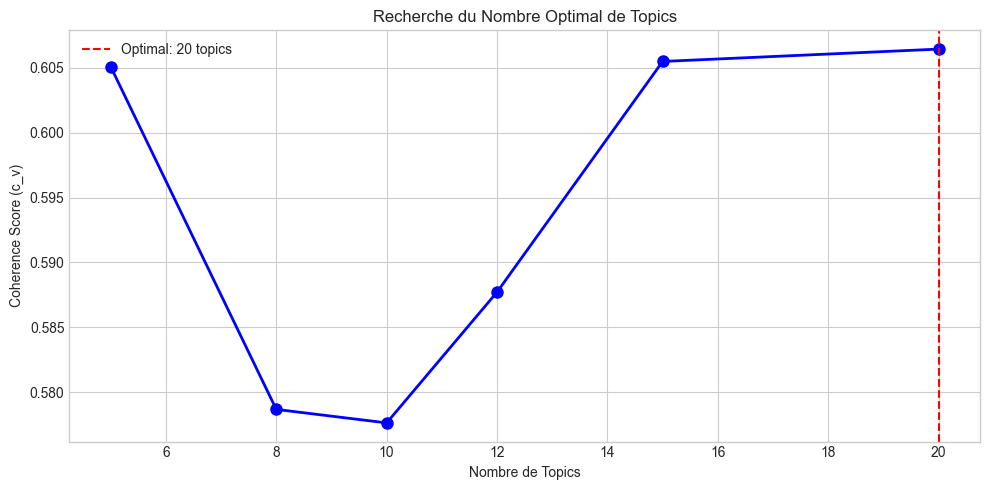

In [12]:
# Visualisation de la recherche
plt.figure(figsize=(10, 5))
plt.plot(topics_range, coherence_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_num_topics, color='r', linestyle='--', label=f'Optimal: {best_num_topics} topics')
plt.xlabel('Nombre de Topics')
plt.ylabel('Coherence Score (c_v)')
plt.title('Recherche du Nombre Optimal de Topics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('lda_optimal_topics.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Application : Proposition de Mots-Clés pour une Question

In [13]:
def suggest_keywords_lda(text, lda_model, dictionary, num_keywords=5):
    """
    Propose des mots-clés pour un texte donné en utilisant LDA.
    
    1. Convertit le texte en BoW
    2. Trouve le topic dominant
    3. Retourne les mots-clés de ce topic
    """
    # Tokenization (même pipeline que l'entraînement)
    tokens = text.lower().split()
    
    # Conversion en BoW
    bow = dictionary.doc2bow(tokens)
    
    # Obtenir la distribution des topics
    topic_distribution = lda_model.get_document_topics(bow)
    
    # Trouver le topic dominant
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    topic_id, topic_prob = dominant_topic
    
    # Obtenir les mots-clés du topic dominant
    topic_words = lda_model.show_topic(topic_id, topn=num_keywords)
    keywords = [word for word, _ in topic_words]
    
    return {
        'dominant_topic': topic_id + 1,
        'topic_probability': topic_prob,
        'suggested_keywords': keywords,
        'all_topics': [(t+1, round(p, 3)) for t, p in topic_distribution]
    }

print(" Fonction de suggestion définie")

 Fonction de suggestion définie


In [14]:
# Test avec des exemples de questions
test_questions = [
    "how to connect python to mysql database and execute query",
    "javascript function onclick event handler not working",
    "android activity lifecycle fragment transaction",
    "css flexbox align items center responsive design"
]

print("TEST DE SUGGESTIONS DE MOTS-CLÉS (LDA)")

for question in test_questions:
    result = suggest_keywords_lda(question, lda_model, dictionary)
    print(f"\n Question : '{question}'")
    print(f"    Topic dominant : {result['dominant_topic']} (prob: {result['topic_probability']:.2f})")
    print(f"    Mots-clés suggérés : {', '.join(result['suggested_keywords'])}")

TEST DE SUGGESTIONS DE MOTS-CLÉS (LDA)

 Question : 'how to connect python to mysql database and execute query'
    Topic dominant : 7 (prob: 0.59)
    Mots-clés suggérés : table, database, query, select, sql

 Question : 'javascript function onclick event handler not working'
    Topic dominant : 10 (prob: 0.32)
    Mots-clés suggérés : div, function, class=, text, html

 Question : 'android activity lifecycle fragment transaction'
    Topic dominant : 1 (prob: 0.28)
    Mots-clés suggérés : public, int, new, string, android

 Question : 'css flexbox align items center responsive design'
    Topic dominant : 3 (prob: 0.46)
    Mots-clés suggérés : n't, like, using, would, way


## 9. Sauvegarde du Modèle

In [ ]:
import os

# Créer le dossier de sortie
os.makedirs('../models/lda', exist_ok=True)

# Sauvegarder le modèle LDA
lda_model.save('../models/lda/lda_model.gensim')

# Sauvegarder le dictionnaire
dictionary.save('../models/lda/dictionary.gensim')

print("\n Modèle LDA sauvegardé dans ./models/lda/")


 Modèle LDA sauvegardé dans ./models/lda/


## 10. Résumé et Comparaison avec l'Approche Supervisée


1. **Topic Modeling avec LDA** :
   - Découverte de thèmes latents dans le corpus
   - Chaque thème = ensemble de mots-clés
   - Coherence Score : mesure de la qualité des topics

2. **Visualisation** :
   - Distribution des mots par topic
   - Visualisation 2D interactive avec pyLDAvis

3. **Recherche d'hyperparamètres** :
   - Test de différents nombres de topics
   - Sélection basée sur le Coherence Score

### Limites de l'approche non supervisée :

- **Pas d'évaluation directe** : Les topics ne correspondent pas forcément aux tags existants
- **Interprétation subjective** : Les thèmes doivent être interprétés manuellement
- **Généralité** : Les mots-clés sont génériques, pas spécifiques à une question
